- Exercici 1
Descarrega el dataset adjunt, de registres de publicacions a Facebook sobre Tailàndia, i classifica els diferents registres utilitzant l'algorisme de K-means.

 Important

Tingues en compte que prèviament et caldrà preparar el dataset.



- Exercici 2
Classifica els diferents registres utilitzant l'algorisme de clustering jeràrquic.



- Exercici 3
Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.



In [15]:
import pandas as pd
import numpy as np



from sklearn.preprocessing  import RobustScaler
from sklearn.decomposition import PCA


import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("Publicacions Facebook Thailandia (1).csv")
df.head(5)


,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


In [16]:
df.isnull().sum()

status_id              0
status_type            0
status_published       0
num_reactions          0
num_comments           0
num_shares             0
num_likes              0
num_loves              0
num_wows               0
num_hahas              0
num_sads               0
num_angrys             0
Column1             7050
Column2             7050
Column3             7050
Column4             7050
dtype: int64

 Vemos columnas vacías (7050 null) y dtypes que no nos convienen (object). Haremos limpieza 


In [17]:
 # columnas Null

df = df.drop(['Column1','Column2','Column3','Column4'], axis = 1)


# Eliminamos tb la columna status_id pues no vemos que info nos puede aportar 

df = df.drop(['status_id'], axis = 1)


# Convert dtypes

df = df.convert_dtypes()




df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   status_type       7050 non-null   string
 1   status_published  7050 non-null   string
 2   num_reactions     7050 non-null   Int64 
 3   num_comments      7050 non-null   Int64 
 4   num_shares        7050 non-null   Int64 
 5   num_likes         7050 non-null   Int64 
 6   num_loves         7050 non-null   Int64 
 7   num_wows          7050 non-null   Int64 
 8   num_hahas         7050 non-null   Int64 
 9   num_sads          7050 non-null   Int64 
 10  num_angrys        7050 non-null   Int64 
dtypes: Int64(9), string(2)
memory usage: 667.9 KB


In [18]:
df['status_type'].unique()

<StringArray>
['video', 'photo', 'link', 'status']
Length: 4, dtype: string

No nos vayamos a olvidar de eliminar los valores duplicados...

In [19]:
df.shape

(7050, 11)

In [20]:
df.drop_duplicates(inplace= True) 

In [21]:
df.shape

(6996, 11)

Efectivamente, eliminamos 54 elementos duplicados.\
Veamos si existen correlaciones relevantes.

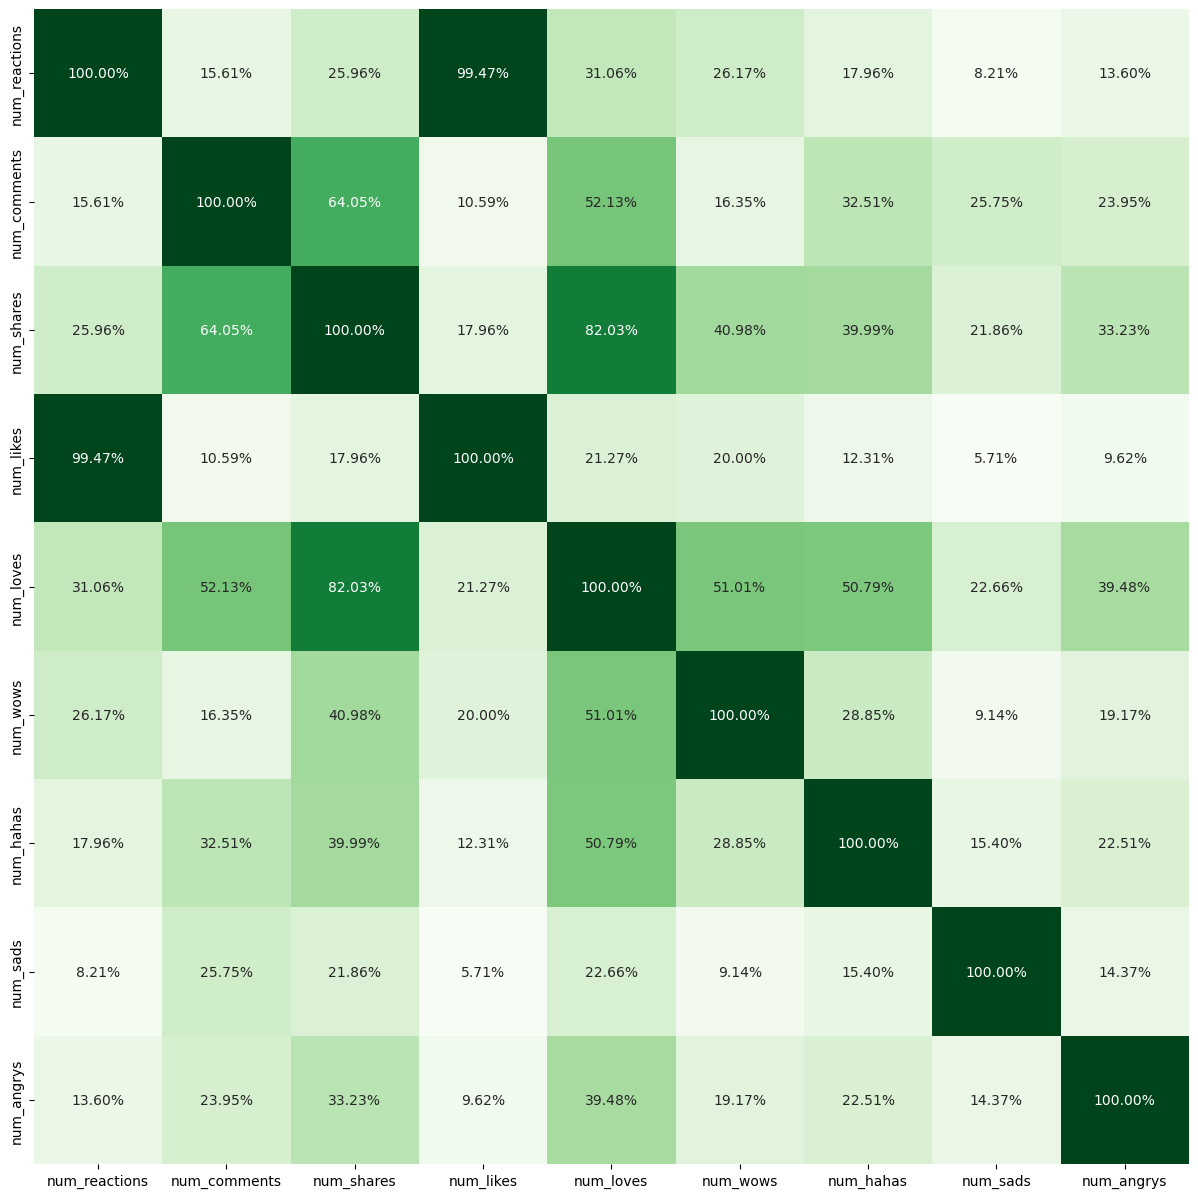

In [22]:
corr = df.corr()

plt.figure(figsize=(15,15))


heatmap =sns.heatmap(corr, cbar = False, square= True, fmt='.2%', annot=True, cmap='Greens')

In [23]:
#Que correlaciones son relevantes ? 
#Definimos previamente el valor para una alta correlación (Threshold) e Iteramos sobre el DF.corr

Threshold = 75/100

for i in range(len(corr.columns)):
    for j in range(i+1,len(corr.columns)):
        if abs(corr.iloc[i,j])>Threshold:
            column1 = corr.columns[i]
            column2 = corr.columns[j]
            corr_value = corr.iloc[i,j]
            
            print(f"Las columnas'{column1}' y '{column2}' tienen una correlación significativa de '{corr_value:.2f}'")


Las columnas'num_reactions' y 'num_likes' tienen una correlación significativa de '0.99'
Las columnas'num_shares' y 'num_loves' tienen una correlación significativa de '0.82'


# Normalidad y outliers 

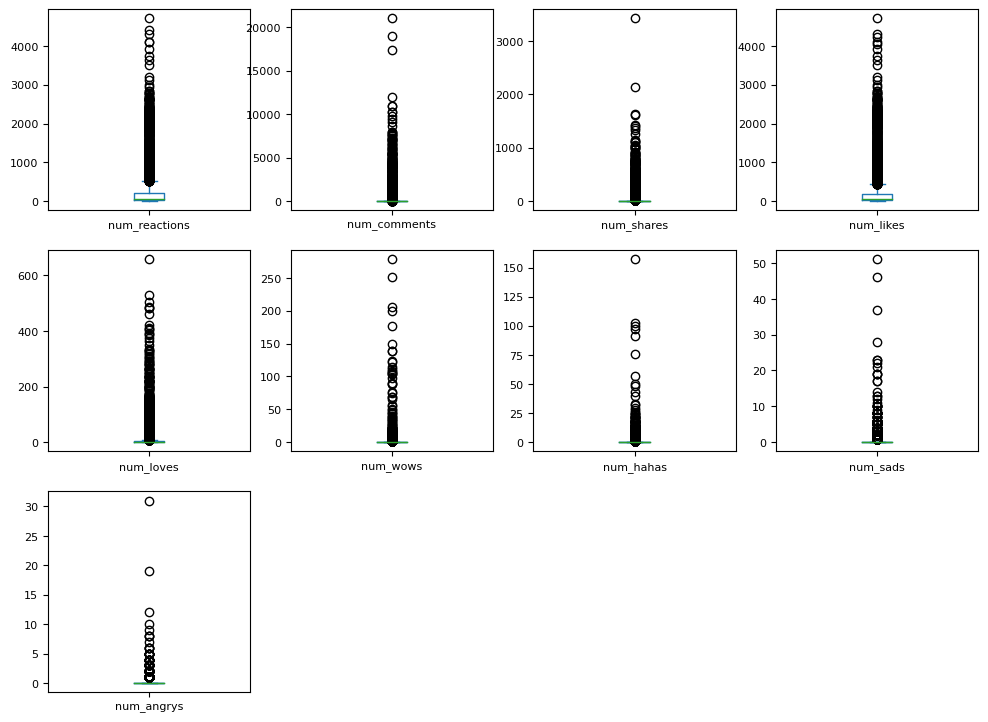

In [24]:
# Outliers

df.plot(kind='box', subplots=True, layout=(4,4), fontsize=8, figsize=(12,12));

Todas tienen outliers, posiblemente apliquemos RobustScaler en el preprocesado.
Deducimos que no guardan una distribución normal pero vamos a confirmar cual es la distibución (  Normalidad/ Gaussiana  ) 

In [25]:
# Queremos Aplicar Shapiro pero nos "saltará" para valores no numéricos . Creamos lista con columnas con valores numéricos

columns_numeric = []

for column in df:
    if df[column].dtype == 'Int64':
        columns_numeric.append(column)
print(columns_numeric)

['num_reactions', 'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']


In [26]:
#Normalidad . Comprobamos si las variables numéricas son gaussianas o no, para ver si usamos RobustScaler

from scipy.stats import shapiro
    
for i in columns_numeric:
        data = df[i]       
        stat, p = shapiro(data)
        print('stat=%.3f, p=%.3f' % (stat, p))
        if p > 0.05:
            print(i+  '  Probablemente gaussiana')
        else:
                print(i + '   Probablemente no gaussiana')


stat=0.508, p=0.000
num_reactions   Probablemente no gaussiana
stat=0.262, p=0.000
num_comments   Probablemente no gaussiana
stat=0.338, p=0.000
num_shares   Probablemente no gaussiana
stat=0.487, p=0.000
num_likes   Probablemente no gaussiana
stat=0.353, p=0.000
num_loves   Probablemente no gaussiana
stat=0.106, p=0.000
num_wows   Probablemente no gaussiana
stat=0.148, p=0.000
num_hahas   Probablemente no gaussiana
stat=0.136, p=0.000
num_sads   Probablemente no gaussiana
stat=0.141, p=0.000
num_angrys   Probablemente no gaussiana


Las variables  tienen una distribución no gaussiana, podremos aplicar Robust Scaler.

# PCA

 Aplicamos una standarización previa para columnas numéricas. 
Crearemos previamente los dummies para status_type ( categórica) y así podremos eliminarla y tendremos vía libre para aplicar RobustScaler . 
Más adelante haremos un Concat entre el Dataframe de las PCA y estos Dummies y obtendremos el DF con el que testear Kmeans


In [27]:
df

,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0
1,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0
2,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0
3,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0
4,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7045,photo,9/24/2016 2:58,89,0,0,89,0,0,0,0,0
7046,photo,9/23/2016 11:19,16,0,0,14,1,0,1,0,0
7047,photo,9/21/2016 23:03,2,0,0,1,1,0,0,0,0
7048,photo,9/20/2016 0:43,351,12,22,349,2,0,0,0,0


In [28]:
# Creamos Dummies para la columna  'status_type' : Video/ Photo.....dtype = int64

z = pd.get_dummies(df['status_type'], drop_first=True, dtype='int64')

z.reset_index(inplace= True)
z.drop(['index'], axis=1, inplace= True)
z

,photo,status,video
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,1,0,0
...,...,...,...
6991,1,0,0
6992,1,0,0
6993,1,0,0
6994,1,0,0


In [29]:
# Eliminamos la col.status_type una vez ya hemos creado los dummies, eliminampos tb la columna  status_published 
df1= df.copy()
df1.drop(['status_type','status_published'], axis = 1, inplace= True)
df1.shape

(6996, 9)

In [30]:
# Podemos aplicar un RobustScaler pues no tienen una distribución Normal ( Gaussiana )

names2 = df1.columns

Scaled_df = RobustScaler().fit_transform(df1) 
df_scaled = pd.DataFrame(Scaled_df, columns = names2)
df_scaled.dropna(axis=0, inplace =  True)
df_scaled

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,2.366834,22.831461,65.50,2.272727,30.666667,3.0,1.0,1.0,0.0
1,0.462312,-0.179775,0.00,0.563636,0.000000,0.0,0.0,0.0,0.0
2,0.849246,10.426966,14.25,0.890909,7.000000,1.0,1.0,0.0,0.0
3,0.266332,-0.179775,0.00,0.327273,0.000000,0.0,0.0,0.0,0.0
4,0.778894,-0.179775,0.00,0.890909,3.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
6991,0.155779,-0.179775,0.00,0.193939,0.000000,0.0,0.0,0.0,0.0
6992,-0.211055,-0.179775,0.00,-0.260606,0.333333,0.0,1.0,0.0,0.0
6993,-0.281407,-0.179775,0.00,-0.339394,0.333333,0.0,0.0,0.0,0.0
6994,1.472362,0.359551,5.50,1.769697,0.666667,0.0,0.0,0.0,0.0



Una vez tenemos el DF Scaled, vamos a aplicar una Dimensionality Reduction PCA, vamos  buscar el nº de dimensiones que optimizan la extracción de Varianza con el mínimo numero de características del dataset 

In [31]:
#Iniciamos PCA, queremos conservar 90% de la varianza 

from sklearn.decomposition import PCA


pca = PCA(0.90)

# Fit_transform

data_pca = pca.fit_transform(df_scaled)
pca.n_components_ 

2

Nos dice que con los 2 primeros PCA mantendríamos esta varianza ( 90% ). Pasamos a DF

In [32]:
pca.components_df = pd.DataFrame(data_pca, columns = ['PCA1','PCA2'])

In [33]:
# panda concat una vez tenemos los dummies para Video, photo y tenemos los pca.components_


df_def = pd.concat([pca.components_df, z], axis = 1, copy = True)
df_def.dropna( axis=0, inplace =  True)
df_def.reset_index(inplace= True)
df_def.drop(['index'], axis=1, inplace= True)
df_def

,PCA1,PCA2,photo,status,video
0,48.357696,38.956244,0,0,1
1,-14.809157,-2.187481,1,0,0
2,3.390220,3.411421,0,0,1
3,-14.813287,-2.194082,1,0,0
4,-14.196754,-1.345622,1,0,0
...,...,...,...,...,...
6991,-14.815616,-2.197805,1,0,0
6992,-14.722787,-2.090011,1,0,0
6993,-14.757526,-2.120176,1,0,0
6994,-10.971379,1.601805,1,0,0


# KMEANS

In [34]:
#Vamos a buscar el nº óptimo de clusters con el método Elbow

from sklearn.cluster import KMeans
inertia = []



for k in range(2,15):
        Kmeans = KMeans(n_clusters=k, max_iter = 100, random_state = 42,algorithm = 'elkan')
        Kmeans.fit(df_def)
        inertia.append(Kmeans.inertia_)

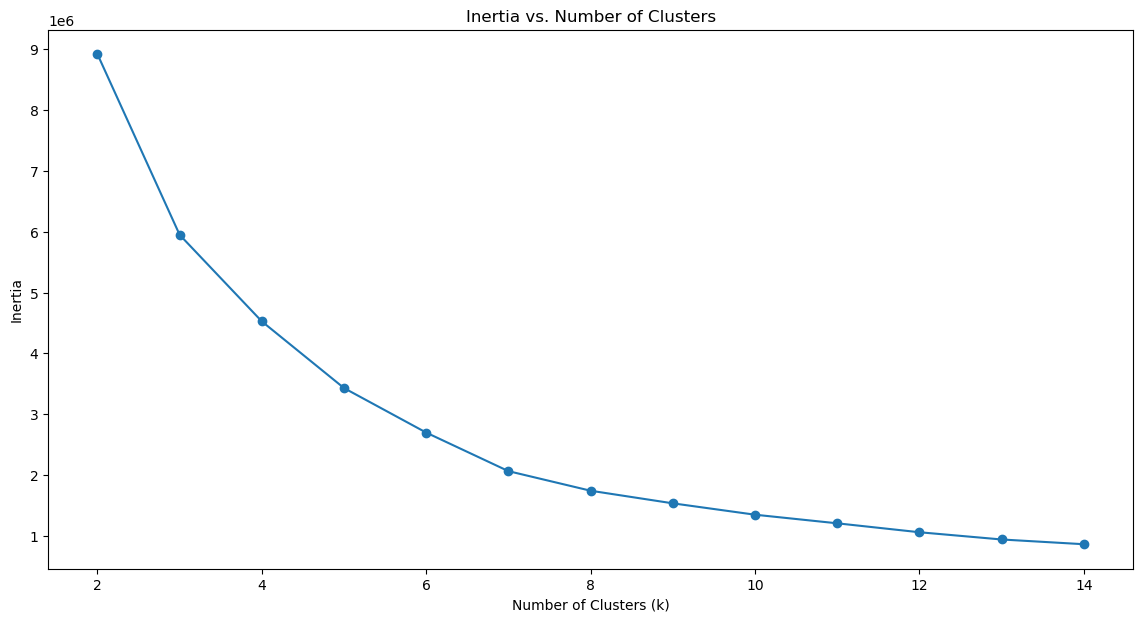

In [35]:
# Plot

plt.figure(figsize=(14,7))
plt.plot(range(2,15), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia vs. Number of Clusters')
plt.show()



 Vemos que el punto de inflexión corresponde a 3 Clusters (o 4 Clusters) 
 

In [37]:
# Training del modelo con n_clusters = 3 clusters


Kmeans_3 = KMeans(n_clusters=3,
                  max_iter = 1000, 
                  random_state = 42,
                  algorithm = 'elkan')

In [38]:
# Ajustamos a nuestros datos ( obtenemos Clusters :  Y )

Y_k3 = Kmeans_3.fit_predict(df_def).astype(int)


In [39]:
# Añadimos Labels que acabamos de crear al df: 

df_def['Cluster']= Y_k3
df_def.reset_index()
df_def.columns

Index(['PCA1', 'PCA2', 'photo', 'status', 'video', 'Cluster'], dtype='object')

In [40]:
# Evaluamos el rendimiento de este clustering K_3 : SSE y Silhouette

#SSE


sse_k3 = Kmeans_3.inertia_
sse_k3

5948837.418812338

In [41]:
#Silhouette


from sklearn.metrics import silhouette_score
silhouette_k3 = silhouette_score(df_def,Y_k3)

silhouette_k3

0.8742556591258908

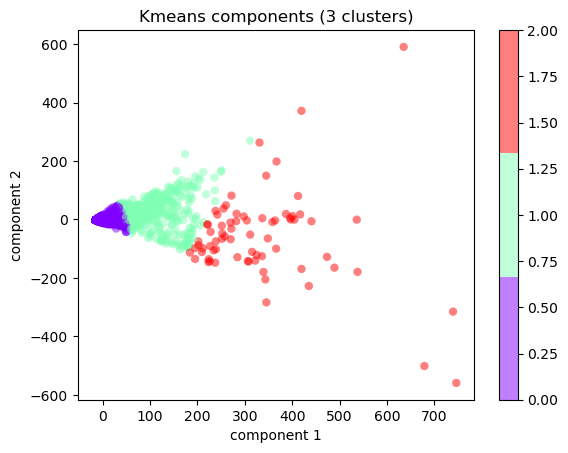

In [42]:
#Scatterplot de los Components para Kmeans

plt.scatter(df_def['PCA1'], df_def['PCA2'],
            c=df_def['Cluster'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', 3))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Kmeans components (3 clusters)')
plt.colorbar();

Se distinguen claramente  tres clusters. Más adelante veremos las características de estos.

# Hierarchical clustering

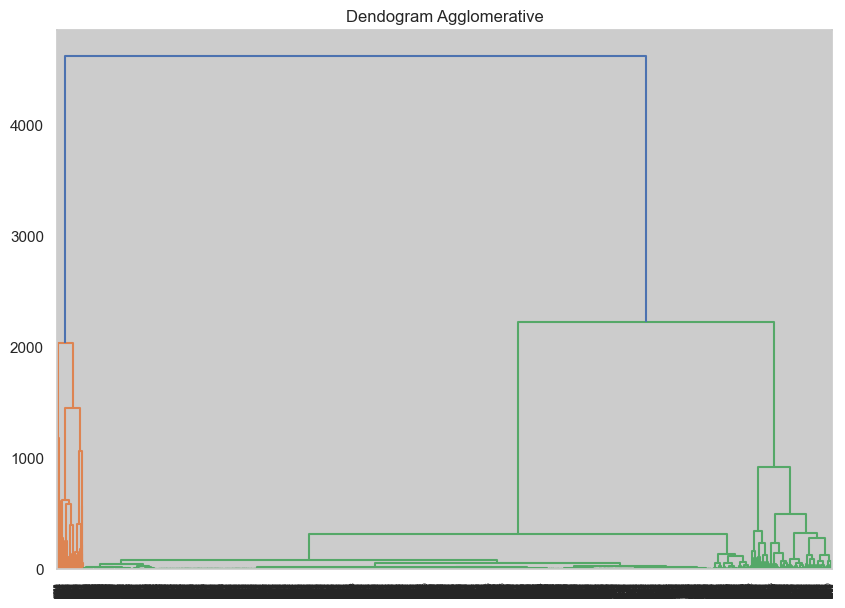

In [694]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
dend_ward = shc.dendrogram(shc.linkage(df_def, method='ward'))
plt.title("Dendogram Agglomerative")
plt.show()

el numero óptimo de Clusters en este caso sería 2 ( 3 (nº colores) - 1).
Podemos confirmar trazando Silhouette de nuevo para Hierarchical Clustering

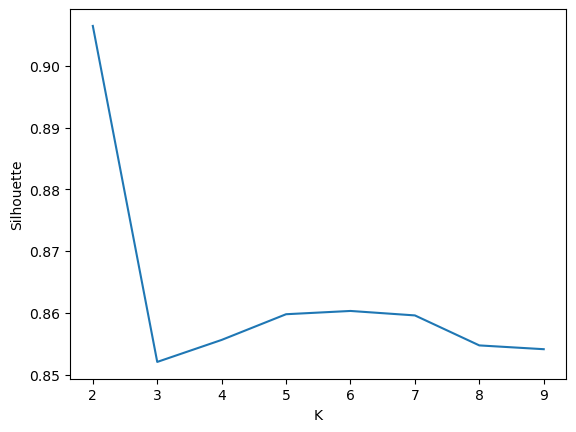

In [43]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

silhouette2 = []

for k in range (2,10):
    AG = AgglomerativeClustering(n_clusters=k ,affinity='euclidean', linkage='ward')
    cluster_labels = AG.fit_predict(df_def)
    silhouette2.append((silhouette_score(df_def, cluster_labels)))

#print(silhouette_coefficients)

plt.plot(range(2, 10), silhouette2)
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.show()



2 Clusters serían el óptimo si utilizamos Hierarchical clustering, el Score de Silhouette baja drásticamente a partir de k>2
Aplicamos este nº óptimo de Clusters 

In [44]:
from sklearn.cluster import AgglomerativeClustering

cluster2 = AgglomerativeClustering(n_clusters = 2 , affinity = 'euclidean', linkage = 'ward')    
Y_AGG2 = cluster2.fit_predict(df_def).astype(int) # Ajustamos y predecimos Labels

In [45]:
# Añadimos Labels que acabamos de crear al df: 
df_AGG = df_def.copy()

df_AGG['Cluster']= Y_AGG2
df_AGG.reset_index()
df_AGG.columns


Index(['PCA1', 'PCA2', 'photo', 'status', 'video', 'Cluster'], dtype='object')

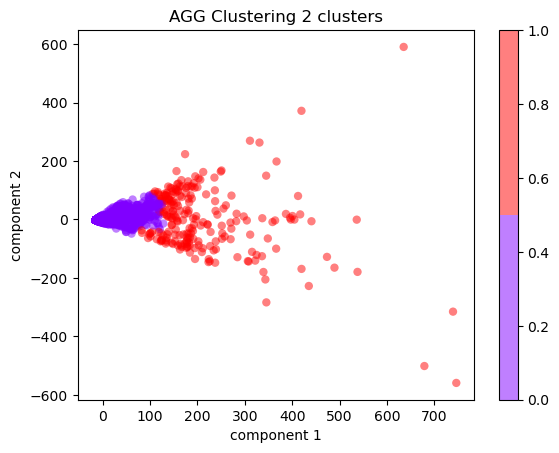

In [46]:
#Scatterplot de los Components 

plt.scatter(df_AGG['PCA1'], df_AGG['PCA2'],
            c=df_AGG['Cluster'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('AGG Clustering 2 clusters')
plt.colorbar();

Con Hierarchical Clustering obtenemos 2 clusters como óptimo, con Kmeans obtuvimos 3. Si comparamos scatteplots para Hierarchical Clustering  y Kmeans vemos como el 3er cluster de Kmeans desaparece en beneficio del 2º.También vemos como el primer Cluster "gana" un poco de espacio del segundo. Además Hierarchical nos da un mejor score de Silhouette como vemos aquí abajo.

In [47]:
#Silhouette AGG K = 2

from sklearn.metrics import silhouette_score
silhouette_AGG = silhouette_score(df_def,Y_AGG2)

silhouette_AGG

0.9064537429729271

# EX3

In [701]:
#Resumen de Scores:

data = [['', silhouette_k3], ['', silhouette_AGG]]
 
# Create the pandas DataFrame
Resumen_scores = pd.DataFrame(data, columns = ['','Silhouette'] ,index =['KMEANS 3 Clusters', 'AGG 2 Clusters'])
 
# print dataframe.
Resumen_scores


,,Silhouette
KMEANS 3 Clusters,,0.874256
AGG 2 Clusters,,0.906454


Vamos a buscar las características de estos clusters para Kmeans (3 clusters: Y_k3 ) y AGG ( 2 clusters: Y_AGG2 ).\

In [725]:
#Concat de Labels creados ( Clusters) y DF original .

# Pasamos Labels a DF
Y_k3_df = pd.DataFrame(Y_k3,columns = ['Kmeans Labels']) # Labels para Kmeans con k = 3
Y_AGG2_df = pd.DataFrame(Y_AGG2,columns = ['Hierarchical Clusters']) # Labels para AGG con k = 2

# Concat con DF original 
df_K3 = pd.concat([df, Y_k3_df], axis = 1, copy = True)
df_AGG2 = pd.concat([df, Y_AGG2_df], axis = 1, copy = True)

df_K3.dropna(axis=0, inplace = True)
df_AGG2.dropna(axis=0, inplace = True)

df_K3.tail(3) # Clusters Kmeans (3) en DF original

,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Kmeans Labels
6993,photo,3/1/2017 1:13,9,0,2,6,2,0,1,0,0,0.0
6994,photo,2/22/2017 3:11,129,4,4,126,1,1,1,0,0,0.0
6995,photo,2/11/2017 11:40,685,1,7,678,5,1,1,0,0,0.0


In [724]:
df_AGG2.tail(3) # Clusters AGG (2) en DF original

,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Hierarchical Clusters
6993,photo,3/1/2017 1:13,9,0,2,6,2,0,1,0,0,0.0
6994,photo,2/22/2017 3:11,129,4,4,126,1,1,1,0,0,0.0
6995,photo,2/11/2017 11:40,685,1,7,678,5,1,1,0,0,0.0


In [726]:
# Calculamos las medias por segmentos 



df_pca_freq_Kmeans = df_K3.groupby(['Kmeans Labels']).mean().sort_values(by='num_reactions', ascending = True)
df_pca_freq_AGG = df_AGG2.groupby(['Hierarchical Clusters']).mean().sort_values(by='num_reactions', ascending = True)

# Creamos una columna " Engagement" para ver las reacciones proporcionales en las variables de engagement
df_pca_freq_Kmeans['Engagement Clusters Kmeans'] = df_pca_freq_Kmeans['num_loves']/ df_pca_freq_Kmeans['num_reactions']*100

# Creamos una columna " Difusion" (num_shares + num_comments) 
df_pca_freq_Kmeans['Difusión'] = (df_pca_freq_Kmeans['num_shares']+df_pca_freq_Kmeans['num_comments'])/ (df_pca_freq_Kmeans['num_reactions']+df_pca_freq_Kmeans['num_comments'])*100

# Creamos una columna " Volumen" (nº de elementos para cada clustert...Labels.count_values) 


df_pca_freq_Kmeans.T

Kmeans Labels,0.0,1.0,2.0
num_reactions,215.598348,347.741794,382.927536
num_comments,166.337594,739.308534,2511.376812
num_shares,29.323254,172.078775,213.188406
num_likes,204.438903,283.940919,318.289855
num_loves,9.348036,55.568928,55.391304
num_wows,0.964931,5.159737,2.898551
num_hahas,0.558136,2.094092,4.594203
num_sads,0.198878,0.577681,1.275362
num_angrys,0.086502,0.400438,0.478261
Engagement Clusters Kmeans,4.335857,15.979939,14.465218


In [735]:
df_pca_freq_Kmeans.corr()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Engagement Clusters Kmeans,Difusión
num_reactions,1.000000,0.819704,0.999904,0.995227,0.979245,0.718318,0.896100,0.881285,0.999928,0.949022,0.999516
num_comments,0.819704,1.000000,0.827577,0.871688,0.686597,0.190312,0.988770,0.993084,0.812757,0.597370,0.837126
num_shares,0.999904,0.827577,1.000000,0.996486,0.976337,0.708591,0.902175,0.887760,0.999664,0.944555,0.999852
num_likes,0.995227,0.871688,0.996486,1.000000,0.954792,0.646998,0.935137,0.923196,0.993982,0.913732,0.997781
num_loves,0.979245,0.686597,0.976337,0.954792,1.000000,0.844418,0.787540,0.767209,0.981611,0.993212,0.972466
num_wows,0.718318,0.190312,0.708591,0.646998,0.844418,1.000000,0.334891,0.304258,0.726633,0.900996,0.696329
num_hahas,0.896100,0.988770,0.902175,0.935137,0.787540,0.334891,1.000000,0.999477,0.890698,0.710512,0.909474
num_sads,0.881285,0.993084,0.887760,0.923196,0.767209,0.304258,0.999477,1.000000,0.875538,0.687395,0.895559
num_angrys,0.999928,0.812757,0.999664,0.993982,0.981611,0.726633,0.890698,0.875538,1.000000,0.952744,0.999070
Engagement Clusters Kmeans,0.949022,0.597370,0.944555,0.913732,0.993212,0.900996,0.710512,0.687395,0.952744,1.000000,0.938757


In [738]:
#df_pca_freq_AGG.T

# Creamos una columna " Engagement" para ver las reacciones proporcionales.
df_pca_freq_AGG['Engagement Clusters Hierarchical'] = df_pca_freq_AGG['num_loves']/ df_pca_freq_AGG['num_reactions']*100


# Creamos una columna " Difusion" (num_shares + num_comments) 
df_pca_freq_AGG['Difusión'] = (df_pca_freq_AGG['num_shares']+df_pca_freq_AGG['num_comments'])/ (df_pca_freq_AGG['num_reactions']+df_pca_freq_AGG['num_comments'])*100


df_pca_freq_AGG

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Engagement Clusters Hierarchical,Difusión
Hierarchical Clusters,,,,,,,,,,,
0.0,217.949732,186.079268,34.343843,204.874033,11.108418,1.063206,0.601428,0.204789,0.095033,5.09678,54.55626
1.0,473.050459,1500.798165,231.926606,393.715596,66.518349,7.33945,3.720183,1.151376,0.605505,14.061576,87.784076


In [739]:
df_pca_freq_AGG.corr()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Engagement Clusters Hierarchical,Difusión
num_reactions,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
num_comments,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
num_shares,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
num_likes,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
num_loves,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
num_wows,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
num_hahas,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
num_sads,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
num_angrys,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Engagement Clusters Hierarchical,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Conclusiones 2 clusters Hierarchical :

Cluster 0 con menos engagement y difusión mediana
Cluster 1 con más difusióny más engagement
    
    